In [108]:
# 0) INSTALL + IMPORTS

!pip install yfinance --quiet

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['axes.grid'] = True
plt.rcParams['lines.linewidth'] = 2


In [109]:
# 1) PARAMETERS (REVISED)

ETFS = ["XLC","XLY","XLP","XLE","XLF","XLV","XLI","XLB","XLRE","XLK","XLU"]  # 11 SPDR sectors
BENCH = "SPY"                                                              # benchmark

BOND = "IEF"                                                               # bond ETF fallback
USE_BOND = True                                                            # whether to use bond when risk-off

START = "2018-01-01"                                                        # evaluation start
END   = "2020-12-31"                                                        # evaluation end

LOOKBACK_MOM = 12                                                           # months for momentum
VOL_LOOKBACK = 6                                                            # months for volatility

TOP_N = 2                                                                   # number of sectors to select (try 2 to concentrate)
USE_ABS_MOM = True                                                          # require positive momentum

USE_SPY_SMA_PERIOD = 10                                                     # months for SPY trend filter
USE_SPY_TREND = True                                                        # use SPY trend filter

SCALE_MOM_BY_VOL = True                                                     # scale momentum by recent vol
VOL_TARGET = 0.15                                                            # target annual volatility for exposure scaling
USE_VOL_TARGET = True                                                       # whether to scale exposure

TX_COST = 0                                                                 # ignore transaction cost for simplicity

np.random.seed(42)


In [110]:
# 2) DATA DOWNLOAD + PREP

tickers = ETFS + [BENCH]
if USE_BOND:
    tickers = tickers + [BOND]

# Warm-up buffer so that momentum & SMA are valid from start date
BUFFER = max(LOOKBACK_MOM, USE_SPY_SMA_PERIOD, VOL_LOOKBACK) + 2
DATA_START = (pd.to_datetime(START) - pd.DateOffset(months=BUFFER)).strftime("%Y-%m-%d")

raw = yf.download(tickers, start=DATA_START, end=END, interval='1mo')

# Handle possibility that 'Adj Close' doesn't exist
if 'Adj Close' in raw.columns.get_level_values(1):
    data = raw['Adj Close']
else:
    data = raw['Close']

data = data[ETFS + ([BOND] if USE_BOND else []) + [BENCH]].dropna()

bench = data[BENCH]


/tmp/ipython-input-3054659330.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw = yf.download(tickers, start=DATA_START, end=END, interval='1mo')
[*********************100%***********************]  13 of 13 completed


In [111]:
# 3) SIGNALS: MOMENTUM & VOLATILITY & SPY TREND

returns = data.pct_change().dropna()              # monthly returns for all ETFs

mom = data.pct_change(LOOKBACK_MOM)                # 12-month momentum
vol = returns.rolling(VOL_LOOKBACK).std()          # recent volatility

spy_sma = bench.rolling(USE_SPY_SMA_PERIOD).mean()  # SPY’s 10-month SMA


In [112]:
# 4) BACKTEST LOOP

dates = returns.index                                    # monthly dates aligned with returns
strategy_returns = []                                    # container for strategy returns

# start i from a safe offset so lookbacks and SMA exist
min_i = max(LOOKBACK_MOM, VOL_LOOKBACK, USE_SPY_SMA_PERIOD)

for i in range(min_i, len(dates)):
    date = dates[i]                                      # current signal date

    # --- SPY Trend Filter ---
    spy_trend_ok = True
    if USE_SPY_TREND:
        if i < len(bench) and not np.isnan(spy_sma.iloc[i]):
            spy_trend_ok = (bench.iloc[i] > spy_sma.iloc[i])
        else:
            spy_trend_ok = True                          # default if not enough data

    # --- Momentum + Volatility ---
    if i >= len(mom) or i >= len(vol):                   # safety check for bounds
        strategy_returns.append(0.0)
        continue

    mom_vals = mom.iloc[i][ETFS]                         # momentum for sectors
    vol_vals = vol.iloc[i][ETFS]                         # volatility for sectors

    # skip if NaN everywhere
    if mom_vals.isna().all():
        strategy_returns.append(0.0)
        continue

    if SCALE_MOM_BY_VOL:
        if vol_vals.isna().all():
            strategy_returns.append(0.0)
            continue
        safe_vol = vol_vals.replace(0, np.nan).fillna(vol_vals.max()*2)
        scaled = mom_vals / safe_vol
    else:
        scaled = mom_vals.copy()

    # --- Pick Top Sectors ---
    top = scaled.nlargest(TOP_N).index.tolist()

    # absolute momentum filter
    if USE_ABS_MOM:
        top = [s for s in top if mom_vals[s] > 0]

    # --- Compute Return ---
    if len(top) == 0 or not spy_trend_ok:
        # risk-off: use bond if allowed
        if USE_BOND and BOND in returns.columns:
            if i < len(returns[BOND]):
                ret = returns[BOND].iloc[i]
            else:
                ret = 0.0
        else:
            ret = 0.0
    else:
        rets = returns[top].iloc[i] if i < len(returns) else pd.Series(dtype=float)
        rets = rets.dropna()
        ret = rets.mean() if len(rets) > 0 else 0.0

    # save this month’s return
    strategy_returns.append(ret)

# convert to pandas Series aligned with dates
strategy_returns = pd.Series(strategy_returns, index=dates[min_i:])

Strategy: CAGR=19.6%, Sharpe=1.27, MaxDD=-9.6%
SPY:      CAGR=19.9%, Sharpe=0.95, MaxDD=-19.9%


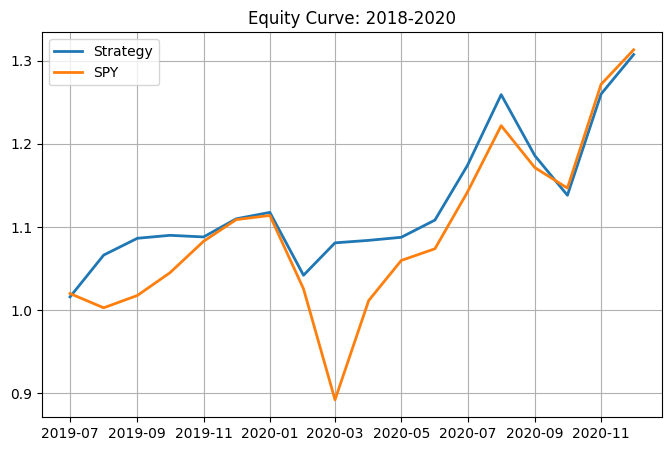

In [113]:
# 5) PERFORMANCE & PLOTS

strategy_series = pd.Series(strategy_returns, index=dates[max(LOOKBACK_MOM, VOL_LOOKBACK, USE_SPY_SMA_PERIOD):])

spy_series = returns[BENCH].loc[strategy_series.index]

def stats(r):
    cagr = (1 + r).prod()**(12/len(r)) - 1
    sharpe = r.mean()/r.std()*np.sqrt(12)
    cum = (1 + r).cumprod()
    dd = (cum - cum.cummax())/cum.cummax()
    return cagr, sharpe, dd.min()

strat_cagr, strat_sharpe, strat_mdd = stats(strategy_series)
spy_cagr, spy_sharpe, spy_mdd = stats(spy_series)

print(f"Strategy: CAGR={strat_cagr:.1%}, Sharpe={strat_sharpe:.2f}, MaxDD={strat_mdd:.1%}")
print(f"SPY:      CAGR={spy_cagr:.1%}, Sharpe={spy_sharpe:.2f}, MaxDD={spy_mdd:.1%}")

cum_strat = (1 + strategy_series).cumprod()
cum_spy = (1 + spy_series).cumprod()

plt.figure(figsize=(8,5))
plt.plot(cum_strat, label='Strategy')
plt.plot(cum_spy, label='SPY')
plt.title('Equity Curve: 2018-2020')
plt.legend()
plt.show()